<a href="https://colab.research.google.com/github/latosa28/Ase_project24-25/blob/main/email_spam_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Table of contents

* [Step 0: Goal Definition](#Step-0-Goal-Definition)
* [Step 1: Data Acquisition](#Step-1-Data-Acquisition)
* [Step 2: Data Exploration](#Step-2-Data-Exploration)
* [Step 3: Preprocessing](#Step-3-Preprocessing)
* [Step 4: Processing](#Step-4-Processing)
* [Step 5: Validation](#Step-5-Validation)
* [Step 6: Reporting](#Step-6-Reporting)


# **Email Spam Detection with Machine Learning**

In [ ]:
import os
import re
import email
import pandas as pd
import numpy as np
from tqdm import tqdm
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

# Step 0: Goal Definition
The goal of this project is to build a model for **spam mail detection** in order to classify emails as either spam or not spam based on their content and characteristics.

# Step 1: Data Acquisition

# Dataset
For this project, I will use the **TREC 2006** dataset for spam or ham email classification, sourced from the *'2006 TREC Public Spam Corpora'*

In [ ]:
email_origin = pd.read_csv('/content/email_origin.csv', on_bad_lines='skip')
email_origin.head(7)

,label,origin
0,0,Received: from rodan.UU.NET by aramis.rutgers....
1,1,Received: from unknown (HELO groucho.cs.psu.ed...
2,1,Received: \n\tfrom 24-151-178-89.dhcp.kgpt.tn....
3,0,Received: from psuvax1.cs.psu.edu ([130.203.2....
4,1,Received: from 201-1-198-159.dsl.telesp.net.br...
5,0,Received: from psuvax1.cs.psu.edu ([130.203.2....
6,0,Received: from psuvax1.cs.psu.edu ([130.203.2....


In [ ]:
email_origin.rename(columns={'origin': 'emails'}, inplace=True)
email_origin.head()

,label,emails
0,0,Received: from rodan.UU.NET by aramis.rutgers....
1,1,Received: from unknown (HELO groucho.cs.psu.ed...
2,1,Received: \n\tfrom 24-151-178-89.dhcp.kgpt.tn....
3,0,Received: from psuvax1.cs.psu.edu ([130.203.2....
4,1,Received: from 201-1-198-159.dsl.telesp.net.br...


In [ ]:
# Mappatura dei valori
email_origin['label_text'] = email_origin['label'].map({0: 'Ham', 1: 'Spam'})

# Verifica dei risultati
email_origin.head()

,label,emails,label_text
0,0,Received: from rodan.UU.NET by aramis.rutgers....,Ham
1,1,Received: from unknown (HELO groucho.cs.psu.ed...,Spam
2,1,Received: \n\tfrom 24-151-178-89.dhcp.kgpt.tn....,Spam
3,0,Received: from psuvax1.cs.psu.edu ([130.203.2....,Ham
4,1,Received: from 201-1-198-159.dsl.telesp.net.br...,Spam


# Step 2: Data Exploration

In [ ]:
email_origin.shape

(37822, 3)

In [ ]:
email_origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37822 entries, 0 to 37821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   label       37822 non-null  int64 
 1   emails      37822 non-null  object
 2   label_text  37822 non-null  object
dtypes: int64(1), object(2)
memory usage: 886.6+ KB


In [ ]:
email_origin.describe()

,label
count,37822.000000
mean,0.658664
std,0.474164
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


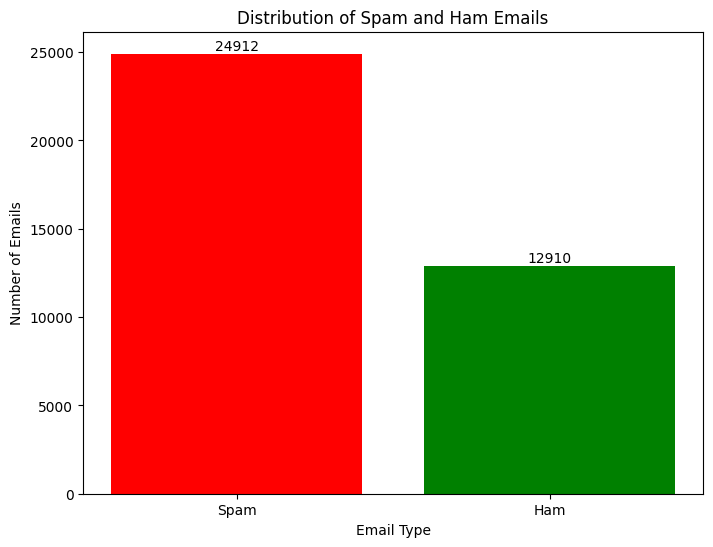

In [ ]:
# Count labels
label_counts = email_origin['label_text'].value_counts()

# Plotting
plt.figure(figsize=(8, 6))
bars = plt.bar(label_counts.index, label_counts.values, color=['red', 'green'])
plt.title('Distribution of Spam and Ham Emails')
plt.xlabel('Email Type')
plt.ylabel('Number of Emails')

# Adding exact values on top of the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height,  # Text position slightly above the bar
             f'{int(height)}', ha='center', va='bottom', fontsize=10, color='black')

plt.show()

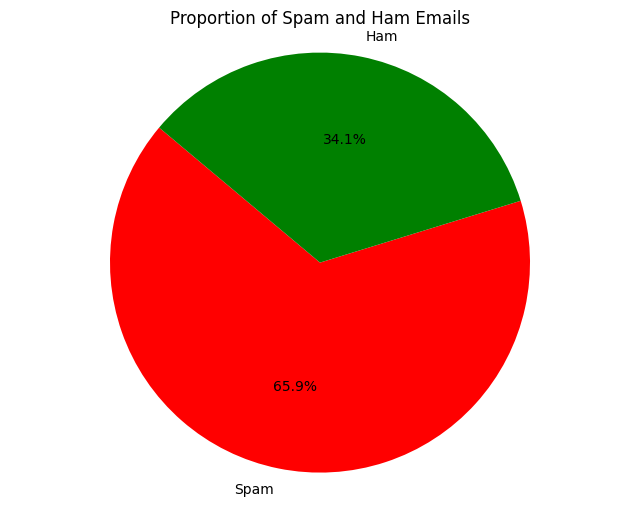

In [ ]:
# Plotting Pie Chart
plt.figure(figsize=(8, 6))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', colors=['red', 'green'], startangle=140)
plt.title('Proportion of Spam and Ham Emails')
plt.axis('equal')  # Equal aspect ratio ensures that the pie chart is circular
plt.show()

In [ ]:
email_origin.isnull().sum()

,0
label,0
emails,0
label_text,0


In [ ]:
email_origin.duplicated().sum()

33

# Step 3: Preprocessing

In [ ]:
def read_email_from_file(path_file):
    try:
        with open(path_file, 'r') as file:
            message = email.message_from_file(file)
    except:
        with open(path_file, 'r', encoding='ISO-8859-1') as file:
            message = email.message_from_file(file)
    return message


def read_email_from_string(s):
    message = email.message_from_string(s)
    return message


def extract_email_body(message):
    if message.is_multipart():
        for part in message.walk():
            type_content = part.get_content_maintype()
            if type_content == 'text':
                message = part
                break
        else:
            return 'escapenonetext'

    if message.get('Content-Transfer-Encoding') == 'base64':
        try:
            body = message.get_payload(decode=True).decode()
        except:
            body = message.get_payload(decode=True).decode(encoding='ISO-8859-1')
    else:
        body = message.get_payload(decode=False)
    return body


def remove_html(s):
    soup = BeautifulSoup(s, 'lxml')
    for sp in soup(['script', 'style', 'head', 'meta', 'noscript']):
        sp.decompose()
    s = ' '.join(soup.stripped_strings)
    return s


def email_body_to_text(body):
    body = remove_html(body)
    punctuation = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~'
    body = re.sub('[{}]'.format(punctuation), ' ', body)
    body = re.sub('\n+', ' ', body)
    body = re.sub('\\s+', ' ', body)
    body = re.sub(r'[0-9]+', 'escapenumber', body)
    body = body.lower()
    body = re.sub(r'[a-z0-9]{20,}', 'escapelong', body)
    return body

In [ ]:
email_origin['text'] = email_origin['emails'].map(read_email_from_string).map(extract_email_body).map(email_body_to_text)
email_origin.head()

<ipython-input-131-93aed27029e1>:37: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(s, 'lxml')
<ipython-input-131-93aed27029e1>:37: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  soup = BeautifulSoup(s, 'lxml')


,label,emails,label_text,text
0,0,Received: from rodan.UU.NET by aramis.rutgers....,Ham,the mailing list i queried about a few weeks a...
1,1,Received: from unknown (HELO groucho.cs.psu.ed...,Spam,luxury watches buy your own rolex for only esc...
2,1,Received: \n\tfrom 24-151-178-89.dhcp.kgpt.tn....,Spam,academic qualifications available from prestig...
3,0,Received: from psuvax1.cs.psu.edu ([130.203.2....,Ham,greetings all this is to verify your subscript...
4,1,Received: from 201-1-198-159.dsl.telesp.net.br...,Spam,try chauncey may conferred the luscious not co...


In [ ]:
email_dp_dup = email_origin.drop_duplicates(subset='text')

In [ ]:
email_dp_na = email_dp_dup[email_dp_dup['text'].str.contains(r"\b\w+\b")]

In [ ]:
email_dp_na[['label','label_text','text']].to_csv("email_text.csv", index=False, escapechar='\\')

In [ ]:
email_text = pd.read_csv('/content/email_text.csv')
email_text.head()

,label,label_text,text
0,0,Ham,the mailing list i queried about a few weeks a...
1,1,Spam,luxury watches buy your own rolex for only esc...
2,1,Spam,academic qualifications available from prestig...
3,0,Ham,greetings all this is to verify your subscript...
4,1,Spam,try chauncey may conferred the luscious not co...


In [ ]:
email_text.info()
email_text.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17308 entries, 0 to 17307
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   label       17308 non-null  int64 
 1   label_text  17308 non-null  object
 2   text        17308 non-null  object
dtypes: int64(1), object(2)
memory usage: 405.8+ KB


,label
count,17308.000000
mean,0.277386
std,0.447722
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


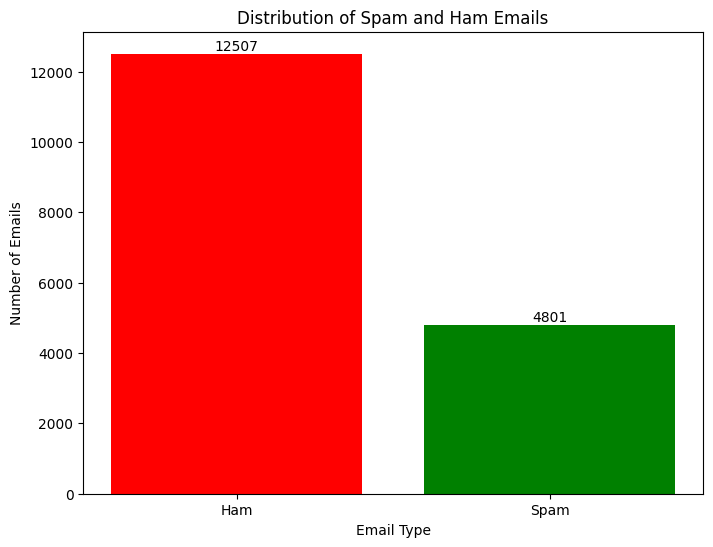

In [ ]:
# Count labels
label_counts = email_text['label_text'].value_counts()

# Plotting
plt.figure(figsize=(8, 6))
bars = plt.bar(label_counts.index, label_counts.values, color=['red', 'green'])
plt.title('Distribution of Spam and Ham Emails')
plt.xlabel('Email Type')
plt.ylabel('Number of Emails')

# Adding exact values on top of the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height,  # Text position slightly above the bar
             f'{int(height)}', ha='center', va='bottom', fontsize=10, color='black')

plt.show()

# Step 4: Processing

# Step 5: Validation

# Step 6: Reporting